# Demo for Keypoint-Guided Optimal Transport

Our approach, KPG-RL, aims to search for correct optimal transport plan guided by the prior annotated keypoints for OT. We propose a mask-based constraint on the transport plan to enforce the exact matching of paired keypoints in transport, and propose to preserve the relation of data to keypoints to realize the guidance of keypoints. KPG-RL can be solved by linear programming and Sinkhorn iteration. 

## Preparing data

Define function to generate samples.

In [1]:
import numpy as np
def get_data(num=10):
    np.random.seed(3)
    data0 = np.random.multivariate_normal(np.array([0,1]),cov=0.05*np.array([[1,0],[0,1]]),size=num)
    data1 = np.random.multivariate_normal(np.array([0,1]),cov=0.05*np.array([[1,0],[0,1]]),size=num)
    data2 = np.random.multivariate_normal(np.array([0,1]),cov=0.05*np.array([[1,0],[0,1]]),size=num)
    data3 = np.random.multivariate_normal(np.array([0,1]),cov=0.05*np.array([[1,0],[0,1]]),size=num)
    source = np.vstack((data0,data1-[0,3]))
    target = np.vstack((data2-[1.5,1.5],data3-[-1.5,1.5]))
    return source,target

The source and target distributions are denoted as $p=\frac{1}{m}\sum_{i=1}^m\delta_{x_i}$ and $q=\frac{1}{n}\sum_{j=1}^n\delta_{y_j}$. The samples are shown in the following figure. 

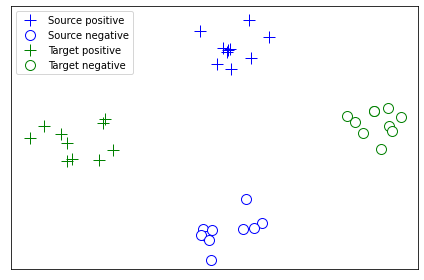

In [2]:
import matplotlib.pyplot as plt
import data

num = 10
source,target = data.get_data(num)
source_positive = source[:num]
source_negative = source[num:]
target_positive = target[:num]
target_negative = target[num:]

plt.plot(source_positive[:,0],source_positive[:,1],'b+',markersize = 12)
plt.plot(source_negative[:,0],source_negative[:,1],'bo',markersize = 10,markerfacecolor="white")
plt.plot(target_positive[:,0],target_positive[:,1],'g+',markersize = 12)
plt.plot(target_negative[:,0],target_negative[:,1],'go',markersize = 10,markerfacecolor="white")
plt.legend(["Source positive","Source negative","Target positive","Target negative"],
           fontsize=10,loc=2)
plt.xlim([-2.2,1.9])
plt.ylim([-2.7,1.6])
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [3]:
m,n = len(source),len(target)
p = np.ones(m)/m
q = np.ones(n)/n

Annotating keypoints.The sets of source/target keypoint indexes are dennoted as $\mathcal{I}=\{i_u\}_{u=1}^U$/$\mathcal{J}=\{j_u\}_{u=1}^U$. The index pairs of keypoints are $\mathcal{K}=\{(i_u,j_u)\}_{u=1}^U$.

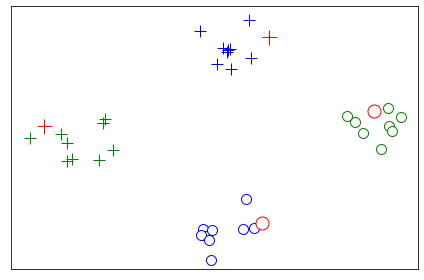

In [4]:
I = [0,num+1]
J = [0,num+1]
plt.plot(source_positive[:,0],source_positive[:,1],'b+',markersize = 12)
plt.plot(source_negative[:,0],source_negative[:,1],'bo',markersize = 10,markerfacecolor="white")
plt.plot(target_positive[:,0],target_positive[:,1],'g+',markersize = 12)
plt.plot(target_negative[:,0],target_negative[:,1],'go',markersize = 10,markerfacecolor="white")
plt.plot(source[I[0]][0],source[I[0]][1],'r+',markersize = 15,linewidth=3)
plt.plot(source[I[1]][0],source[I[1]][1],'ro',markersize = 13,markerfacecolor="white",linewidth=3)
plt.plot(target[J[0]][0],target[J[0]][1],'r+',markersize = 15)
plt.plot(target[J[1]][0],target[J[1]][1],'ro',markersize = 13,markerfacecolor="white")
plt.xlim([-2.2,1.9])
plt.ylim([-2.7,1.6])
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

## Mask-based modeling of the transport plan

The mask-based modeling of the transport plan is to enforce the matching of paired keypoints with indexes in $\mathcal{K}$. We define the mask matrix $M=(M_{i,j})\in \mathbb{R}^{m\times n}$ as $$M_{i,j}=\begin{cases}1 & \mbox{if } (i,j)\in \mathcal{K};\\0 &\mbox{if }i\in \mathcal{I}, (i,j)\notin \mathcal{K};\\0 &\mbox{if }j\in \mathcal{J}, (i,j)\notin \mathcal{K};\\1 &\mbox{otherwise, i.e., }i\notin \mathcal{I}, j\notin \mathcal{J}.\end{cases}$$
The transport plan is then modeled by $\tilde{\pi}=M\odot\pi$, where $\pi\in \mathbb{R}^{m\times n}_+$ is not necessarily a transport plan.The solution set for the optimal transport is $$\Pi(p,q;M) = \{\pi\in\mathbb{R}^{m\times n}_+|(M\odot\pi)\mathbf{1}_n=p, (M\odot\pi)^T\mathbf{1}_m=q\}.$$

In [5]:
M = np.ones([m,n])
M[I,:] = 0
M[:,J] = 0
M[I,J] = 1

We next define the cost matrics $C^s=(C^s_{i,k})\in\mathbb{R}^{m\times m}$ and $C^t=(C^t_{j,l})\in\mathbb{R}^{n\times n}$ for source and target domain respectively, where $C^s_{i,k}=c(x_i,x_k), C^t_{j,l}=c'(y_j,y_l)$. $c$ and $c'$ are set to the squraed $L_2$-distance.

In [6]:
def cost_matrix(x,y):
    Cxy = np.expand_dims((x**2).sum(axis=1),1) + np.expand_dims((y**2).sum(axis=1),0) - 2 * x@y.T
    return Cxy
Cs = cost_matrix(source,source)
Ct = cost_matrix(target,target)

## Modeling the relation to keypoints

The relation score of $x_k$ to source keypoint $x_{i_u}$ is given by $$R_{k,i_u}^s=\frac{\exp\left({-\frac{1}{\tau}C^s_{k,i_u}}\right)}{\sum_{v=1}^U\exp\left({-\frac{1}{\tau}C^s_{k,i_{v}}}\right)}.$$ Similarly, the relation score of $y_l$ to target keypoint $y_{j_u}$ is given by $$R_{l,j_u}^t=\frac{\exp\left({-\frac{1}{\tau'}C^t_{l,j_u}}\right)}{\sum_{v=1}^U\exp\left({-\frac{1}{\tau'}C^t_{l,j_{v}}}\right)}.$$ We set $\tau = \rho*\max_{i,k}{C^s_{i,k}}, \tau' = \rho*\max_{j,l}{C^t_{j,l}}$. The relation of $x_k$ to source keypoints is $$R^s_k=(R^s_{k,i_0},R^s_{k,i_1},\cdots,R^s_{k,i_U}).$$ The relation of target data $y_l$ to target kaypoints is 
$$R^t_l=(R^t_{l,j_0},R^t_{l,j_1},\cdots,R^t_{l,j_U}).$$
Using the relation defined above, we can define the guiding matrix $G=(G_{i,j})\in\mathbb{R}^{m\times n}$ by $G_{ij}=d(R^s_i,R^t_j)$, where $d$ is the Jensen-Shannon divergence.

In [7]:
def guiding_matrix_relation(C1, C2, I, J, rho=0.1):
    S = np.zeros((len(C1), len(C2)))
    C1_kp = C1[:, I]
    C2_kp = C2[:, J]
    R1 = softmax_matrix(-2*C1_kp / rho)
    R2 = softmax_matrix(-2*C2_kp / rho)
    S = JS_matrix(R1, R2)
    return S

def softmax_matrix(x):
    y = np.exp(x - np.max(x))
    f_x = y / np.sum(np.exp(x - np.max(x)), axis=-1, keepdims=True)
    return f_x

def KL_matrix(p, q, eps=1e-10):
    return np.sum(p * np.log(p + eps) - p * np.log(q + eps), axis=-1)

def JS_matrix(P, Q, eps=1e-10):
    P = np.expand_dims(P, axis=1)
    Q = np.expand_dims(Q, axis=0)
    kl1 = KL_matrix(P, (P + Q) / 2, eps)
    kl2 = KL_matrix(Q, (P + Q) / 2, eps)
    return 0.5 * (kl1 + kl2)

In [8]:
Cs = Cs/Cs.max()
Ct = Ct/Ct.max()
G = guiding_matrix_relation(Cs,Ct,I,J,rho=0.5)

## KeyPoint-Guided model by ReLation (KPG-RL) preservation.

The KPG-RL model is defined by $$\min_{\pi\in\Pi(p,q;M)}{\langle M\odot\pi, G\rangle_F}.$$
The KPG-RL model can be solved by linear programming and Sinkhorn's algorithm.

## Solving KPG-RL

For linear programming, We cast the matrix $G$ (resp. $M, \pi$) as the vector $\mathbf{c}\text{ (resp. $\mathbf{m},\mathbf{x}$)}\in\mathbb{R}^{mn}$, such that the ($i+m(j-1)$)-th element of $\mathbf{c}$ is $G_{ij}$. By denoting 
$$
    A = \left[
    \begin{matrix}
    \mathbf{1}_n^{\top}\otimes I_{m}\\
    I_n\otimes \mathbf{1}_m
    \end{matrix}\right]*\mbox{diag}(\mathbf{m}), 
    \mathbf{h} = \left[
    \begin{matrix}
    {p}\\
    {q}
    \end{matrix}\right], \mbox{ and } \tilde{\mathbf{c}} = \mathbf{c}\odot\mathbf{m},
$$
where $I_m$ is the identity matrix of size $n$ and $\otimes$ is the Kronecker product, 
the KPG-RL model reads
$$ \label{eq:lp_form}
    \begin{split}
        &\min_{\mathbf{x}} \tilde{\mathbf{c}}^{\top}\mathbf{x}\\
        &s.t. \hspace{0.2cm} \mathbf{x}\geq 0 ,\\
        & \hspace{0.6cm} A\mathbf{x} = \mathbf{h}.
    \end{split}
$$
 

In [9]:
import numpy as np
import cvxpy as cvx
import scipy.optimize._linprog as linprog

def lp(p, q, C, Mask=None):
    c = np.reshape(C.T,(-1,1))
    b = np.vstack((p.reshape(-1,1),q.reshape(-1,1)))
    A = np.vstack((np.kron(np.ones((1,len(q))),np.eye(len(p))),
                   np.kron(np.eye(len(q)),np.ones((1,len(p))))
                   ))
    if Mask is not None:
        m = np.reshape(Mask.T,(-1,1))
        A = A*(m.T)
        c = c*m
    x = cvx.Variable((len(c),1))
    cons = [x>=0,
            A@x==b]
    obj = cvx.Minimize(c.T@x)
    prob = cvx.Problem(obj,cons)
    prob.solve()

#     print(prob.status)
    pi = x.value
    pi = np.reshape(pi,(len(q),len(p)))
    pi = pi.T
    if Mask is not None:
        pi = pi*Mask
    return pi

For Sinkhorn's algorithm,The iterative formulas are 
$$
    \mathbf{u}^{(l+1)} = \frac{\mathbf{p}}{K\mathbf{v}^l}, \hspace{0.2cm}\mathbf{v}^{(l+1)} = \frac{\mathbf{q}}{K^{\top}\mathbf{u}^{(l+1)}},
$$
where $K = M\odot e^{-G/\epsilon}$, $\epsilon$ is the coefficient of entropy regularization. The division operator used above is entry-wise. After iteration, the optimal transport plan is $\mbox{diag}(\mathbf{u})K\mbox{diag}(\mathbf{v})$. The following code is for the log-domain version of Sinkhorn iteration, please refer to Appendix for the details.

In [10]:
def sinkhorn_log_domain(p,q,C,Mask = None, reg=0.01,niter=10000):
    thresh = 1e-10
    def M(u, v):
        M =  (-C + np.expand_dims(u,1) + np.expand_dims(v,0)) / reg
        if Mask is not None:
            M[Mask==0] = -1e6
        return M

    def lse(A):
        "log-sum-exp"
        max_A = np.max(A, axis=1, keepdims=True)
        return np.log(np.exp(A-max_A).sum(1, keepdims=True) + 1e-10) + max_A  

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * p, 0. * q, 0.
    actual_nits = 0  
    for i in range(niter):
        u1 = u  
        u = reg * (np.log(p) - lse(M(u, v)).squeeze()) + u
        v = reg * (np.log(q) - lse(M(u, v).T).squeeze()) + v
        err = np.linalg.norm(u - u1)
        actual_nits += 1
        if err < thresh:
            break
    U, V = u, v
    pi = np.exp(M(U, V))  
    return pi

Visualizing the transport plan solved by linear programming. We transport data using the barycentric mapping.

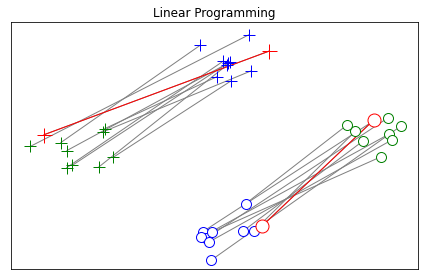

In [11]:
G = G/G.max()
pi = lp(p,q,G,M)
source_transport = pi@target/p.reshape((-1,1))
plt.figure()
for i in range(len(source)):
    plt.plot([source[i][0],source_transport[i][0]],[source[i][1],source_transport[i][1]],
             '-',color="grey",linewidth=1.0)
for i in range(len(I)):
    plt.plot([source[I[i]][0], source_transport[I[i]][0]], [source[I[i]][1],  source_transport[I[i]][1]],
             'r-', linewidth=1.0)
s = 5
plt.plot(source_positive[:,0],source_positive[:,1],'b+',markersize = 12)
plt.plot(source_negative[:,0],source_negative[:,1],'bo',markersize = 10,markerfacecolor="white")
plt.plot(target_positive[:,0],target_positive[:,1],'g+',markersize = 12)
plt.plot(target_negative[:,0],target_negative[:,1],'go',markersize = 10,markerfacecolor="white")
plt.plot(source[I[0]][0],source[I[0]][1],'r+',markersize = 10+s,linewidth=3)
plt.plot(source[I[1]][0],source[I[1]][1],'ro',markersize = 8+s,markerfacecolor="white",linewidth=3)
plt.plot(source_transport[I[0]][0],source_transport[I[0]][1],'r+',markersize = 10+s)
plt.plot(source_transport[I[1]][0],source_transport[I[1]][1],'ro',markersize = 8+s,markerfacecolor="white")
plt.xlim([-2.2,1.9])
plt.ylim([-2.7,1.6])
plt.xticks([])
plt.yticks([])
plt.title("Linear Programming")
plt.tight_layout()
plt.show()
plt.close()

Visualizing the transport plan solved by Sinkhorn's algorithm. We transport data using the barycentric mapping.

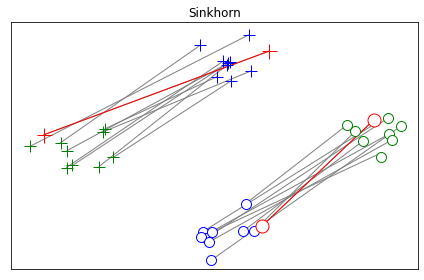

In [12]:
G = G/G.max()
pi = sinkhorn_log_domain(p,q,G,M,reg=1e-6)
source_transport = pi@target/p.reshape((-1,1))
plt.figure()
for i in range(len(source)):
    plt.plot([source[i][0],source_transport[i][0]],[source[i][1],source_transport[i][1]],
             '-',color="grey",linewidth=1.0)
for i in range(len(I)):
    plt.plot([source[I[i]][0], source_transport[I[i]][0]], [source[I[i]][1],  source_transport[I[i]][1]],
             'r-', linewidth=1.0)
s = 5
plt.plot(source_positive[:,0],source_positive[:,1],'b+',markersize = 12)
plt.plot(source_negative[:,0],source_negative[:,1],'bo',markersize = 10,markerfacecolor="white")
plt.plot(target_positive[:,0],target_positive[:,1],'g+',markersize = 12)
plt.plot(target_negative[:,0],target_negative[:,1],'go',markersize = 10,markerfacecolor="white")
plt.plot(source[I[0]][0],source[I[0]][1],'r+',markersize = 10+s,linewidth=3)
plt.plot(source[I[1]][0],source[I[1]][1],'ro',markersize = 8+s,markerfacecolor="white",linewidth=3)
plt.plot(source_transport[I[0]][0],source_transport[I[0]][1],'r+',markersize = 10+s)
plt.plot(source_transport[I[1]][0],source_transport[I[1]][1],'ro',markersize = 8+s,markerfacecolor="white")
plt.xlim([-2.2,1.9])
plt.ylim([-2.7,1.6])
plt.xticks([])
plt.yticks([])
plt.title("Sinkhorn")
plt.tight_layout()
plt.show()